
Performing object detection:
	+ Batch 0, Inference Time: 0:00:01.451772
	+ Batch 1, Inference Time: 0:00:01.346753
	+ Batch 2, Inference Time: 0:00:01.430488
	+ Batch 3, Inference Time: 0:00:01.461685
	+ Batch 4, Inference Time: 0:00:01.350443
	+ Batch 5, Inference Time: 0:00:01.475118
	+ Batch 6, Inference Time: 0:00:01.420398
	+ Batch 7, Inference Time: 0:00:01.484430
	+ Batch 8, Inference Time: 0:00:01.352276
	+ Batch 9, Inference Time: 0:00:01.358302

Saving images:
(0) Image: 'data/custom/images/2010_002436.jpg'
	+ Label: bird, Conf: 0.66048
	+ Label: dog, Conf: 0.51243


<Figure size 432x288 with 0 Axes>

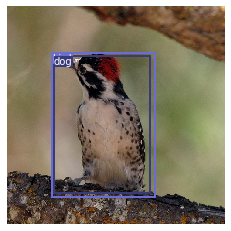

(1) Image: 'data/custom/images/2009_002928.jpg'
	+ Label: bicycle, Conf: 1.00000
	+ Label: pottedplant, Conf: 0.94958


<Figure size 432x288 with 0 Axes>

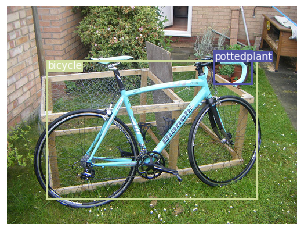

(2) Image: 'data/custom/images/2009_001500.jpg'
	+ Label: horse, Conf: 0.99929
	+ Label: car, Conf: 0.99715
	+ Label: cow, Conf: 0.82959
	+ Label: horse, Conf: 0.79724


<Figure size 432x288 with 0 Axes>

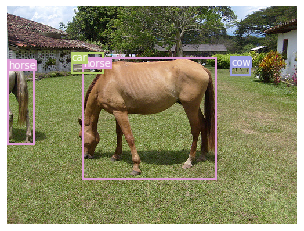

(3) Image: 'data/custom/images/2010_002546.jpg'
	+ Label: person, Conf: 0.99989
	+ Label: bus, Conf: 1.00000
	+ Label: boat, Conf: 0.99667
	+ Label: bus, Conf: 0.99888
	+ Label: boat, Conf: 0.99934
	+ Label: boat, Conf: 0.99421
	+ Label: car, Conf: 0.86548
	+ Label: person, Conf: 0.71307
	+ Label: train, Conf: 0.45363


<Figure size 432x288 with 0 Axes>

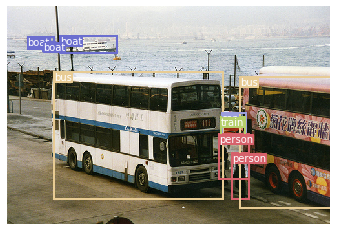

(4) Image: 'data/custom/images/2011_006602.jpg'
	+ Label: person, Conf: 0.99946


<Figure size 432x288 with 0 Axes>

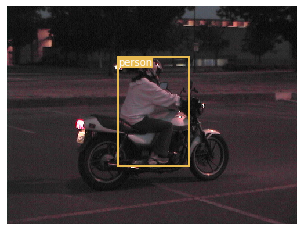

(5) Image: 'data/custom/images/2008_006682.jpg'
	+ Label: dog, Conf: 0.93336


<Figure size 432x288 with 0 Axes>

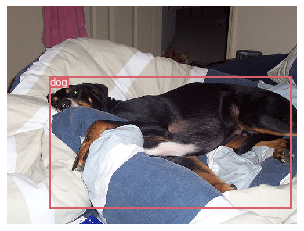

(6) Image: 'data/custom/images/2008_005235.jpg'
	+ Label: cat, Conf: 0.99390


<Figure size 432x288 with 0 Axes>

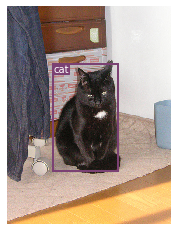

(7) Image: 'data/custom/images/2012_002388.jpg'
	+ Label: person, Conf: 0.99983


<Figure size 432x288 with 0 Axes>

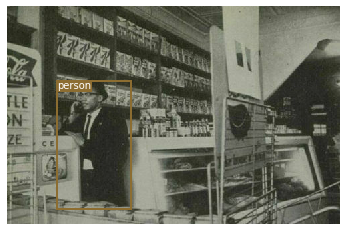

(8) Image: 'data/custom/images/2011_002173.jpg'
	+ Label: train, Conf: 0.90373
	+ Label: boat, Conf: 0.55528


<Figure size 432x288 with 0 Axes>

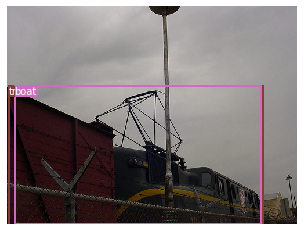

(9) Image: 'data/custom/images/2007_005469.jpg'
	+ Label: cow, Conf: 0.64147
	+ Label: dog, Conf: 0.57436
	+ Label: dog, Conf: 0.53164
	+ Label: horse, Conf: 0.54084
	+ Label: cow, Conf: 0.43100


<Figure size 432x288 with 0 Axes>

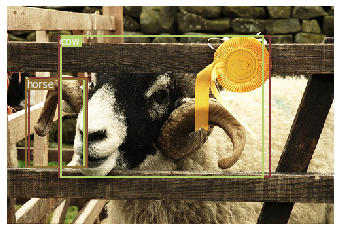

In [15]:
from __future__ import division

from models import *
from utils.utils import *
from utils.datasets import *

import os
import sys
import time
import datetime
import argparse

from PIL import Image

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator


image_folder = "data/custom/images"
model_def = "config/yolov3-custom.cfg"
weights_path = "checkpoints/yolov3_ckpt_309.pth"
class_path = "data/custom/classes.names"
num_of_samples=10
conf_thres = 0.8
nms_thres = 0.4
batch_size = 1
img_size = 416

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("output", exist_ok=True)

model = Darknet(model_def, img_size=img_size).to(device)

if weights_path.endswith(".weights"):
    model.load_darknet_weights(weights_path)
else:
    model.load_state_dict(torch.load(weights_path, map_location=device))

model.eval()

dataloader = DataLoader(
    ImageFolder(image_folder, img_size=img_size),
    batch_size=batch_size,
    shuffle=True
)

classes = load_classes(class_path)

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

imgs = []
img_detections = []

print("\nPerforming object detection:")
prev_time = time.time()
for batch_i, (img_paths, input_imgs) in enumerate(dataloader):
    if batch_i >= num_of_samples:
        break

    input_imgs = Variable(input_imgs.type(Tensor))

    with torch.no_grad():
        detections = model(input_imgs)
        detections = non_max_suppression(detections, conf_thres, nms_thres)

    current_time = time.time()
    inference_time = datetime.timedelta(seconds=current_time - prev_time)
    prev_time = current_time
    print("\t+ Batch %d, Inference Time: %s" % (batch_i, inference_time))

    imgs.extend(img_paths)
    img_detections.extend(detections)

cmap = plt.get_cmap("tab20b")
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

print("\nSaving images:")
for img_i, (path, detections) in enumerate(zip(imgs, img_detections)):
    print("(%d) Image: '%s'" % (img_i, path))

    img = np.array(Image.open(path))
    plt.figure()
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    if detections is not None:
        detections = rescale_boxes(detections, img_size, img.shape[:2])
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:

            print("\t+ Label: %s, Conf: %.5f" % (classes[int(cls_pred)], cls_conf.item()))

            box_w = x2 - x1
            box_h = y2 - y1

            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor="none")
            ax.add_patch(bbox)

            plt.text(
                x1,
                y1,
                s=classes[int(cls_pred)],
                color="white",
                verticalalignment="top",
                bbox={"color": color, "pad": 0},
            )

    plt.axis("off")
    plt.gca().xaxis.set_major_locator(NullLocator())
    plt.gca().yaxis.set_major_locator(NullLocator())
    plt.show()
    plt.close()